In [66]:
from nilearn.plotting import plot_stat_map, plot_roi
import os
import numpy as np
import nibabel as nb
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from tmsfdg_utils import make_spherical_roi 
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

BASE_PATH = os.path.dirname(os.getcwd())

In [67]:
# sgACC based on https://doi.org/10.1016/j.biopsych.2012.04.028
fox_sgACC = make_spherical_roi(coordinates=[6, 16, -10], radius=5)

# alternative ROIs based on https://doi.org/10.1016/j.brs.2019.10.012
ge_sgACC = make_spherical_roi(coordinates=[2, 18, -8], radius=3)

ge_rACC = make_spherical_roi(coordinates=[3, 39, -2], radius=3)

In [68]:
contrasts = BASE_PATH + '/contrasts/'

files = []
for f in os.listdir(contrasts): 
    if '_mni152_sm08.nii.gz' in f:
        files.append(f)

In [69]:

# find where the ROIs are 
ge_rACC_ix = np.where(ge_rACC.get_fdata())
ge_sgACC_ix = np.where(ge_sgACC.get_fdata())
fox_sgACC_ix = np.where(fox_sgACC.get_fdata())

#init
values = {}

for f in files:
    # get name 
    name = f.split('_')[0]
    # load constrast
    img = nb.load(os.path.join(contrasts, f)).get_fdata()

    # calculate mean vals 
    ge_rACC_val = np.mean(img[ge_rACC_ix])
    ge_sgACC_val = np.mean(img[ge_sgACC_ix])
    fox_sgACC_val = np.mean(img[fox_sgACC_ix])
    # store
    values[name] = (ge_rACC_val, ge_sgACC_val, fox_sgACC_val)

# write a df
df = pd.DataFrame.from_dict(values, orient='index').reset_index()
df.columns  = ['subject', 'ge_rACC', 'ge_sgACC', 'fox_sgACC']
df

,subject,ge_rACC,ge_sgACC,fox_sgACC
0,tbsfdg010,-0.027930,-0.019503,-0.009505
1,tbsfdg007,0.018730,0.011195,0.005256
2,tbsfdg011,-0.004865,-0.007332,-0.006814
3,tbsfdg006,-0.012700,-0.008054,-0.008458
4,tbsfdg001,-0.011309,-0.018414,-0.016569
5,tbsfdg031,-0.012598,-0.002137,-0.004951
6,tbsfdg021,0.008111,0.007956,0.009099
7,tbsfdg008,0.008193,0.002501,-0.002253
8,tbsfdg009,0.022709,0.014165,0.008988
9,tbsfdg019,-0.014841,-0.005331,-0.009855


In [107]:
res= {}
for r in ['ge_rACC', 'ge_sgACC', 'fox_sgACC']:
    t, p = stats.ttest_1samp(df[r], 0)
    res[r] = (t,p)
res = pd.DataFrame.from_dict(res, orient='index')
res.columns = ['t-val', 'p-val']
res

,t-val,p-val
ge_rACC,-0.641548,0.530849
ge_sgACC,-0.664427,0.516501
fox_sgACC,-0.827576,0.420882


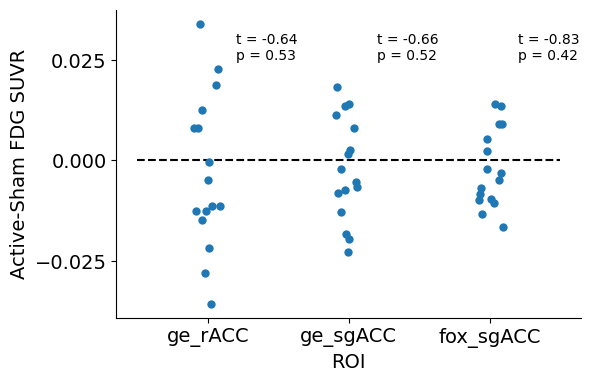

In [125]:
df_long = df.melt(id_vars = 'subject', var_name='ROI', value_name='Active-Sham FDG SUVR')
plt.figure(figsize=(6, 4))
plt.rcParams['font.size'] = 14
sns.stripplot(x='ROI', y='Active-Sham FDG SUVR', data=df_long,size=6)

for x, i in enumerate(res.index):
    txt = 't = ' + str(round(res.loc[i, 't-val'],2)) + '\n' + 'p = ' + str(round(res.loc[i, 'p-val'],2))
    plt.annotate(txt, xy=(x+0.2,0.025), fontsize=10)

plt.hlines(0,-0.5,2.5, linestyles='dashed', color='k')
plt.yticks([-0.025,0,0.025])
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);
plt.savefig(BASE_PATH + '/figures/roi_results.png',dpi=300, bbox_inches ='tight')